# EXERCISE 2  - ML - Grundlagen und Algorithmen

**Contributors**
- uloak (Markus Bilz)
- upomo (Julian Ziegler)
- uhluc (Finn Prox)

## 1.) Multiclass Classification

The Iris Dataset is a very classical machine learning and statistics benchmark for classification, developed in the 1930's. The goal is to classify 3 types of flowers (more specifically, 3 types of flowers form the Iris species) based on 4 features: petal length, petal width, sepal length and sepal width.

As we have $K=3$ different types of flowers we are dealing with a multi-class classification problem and need to extend our sigmoid-based classifier from the previous exercise / recap session. 

We will reuse our "minimize" and "affine feature" functions. Those are exactly as before. The affine features are sufficient here.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestRegressor
from typing import Callable, Tuple

warnings.filterwarnings('ignore')

def minimize(f: Callable , df: Callable, x0: np.ndarray, lr: float, num_iters: int) -> \
        Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """
    :param f: objective function
    :param df: gradient of objective function
    :param x0: start point, shape [dimension]
    :param lr: learning rate
    :param num_iters: maximum number of iterations
    :return argmin, min, values of x for all interations, value of f(x) for all iterations
    """
    # initialize
    x = np.zeros([num_iters + 1] + list(x0.shape))
    f_x = np.zeros(num_iters + 1)
    x[0] = x0
    f_x[0] = f(x0)
    for i in range(num_iters):
        # update using gradient descent rule
        grad = df(x[i])
        x[i + 1] = x[i] - lr * grad
        f_x[i + 1] = f(x[i + 1])
    return x[i+1], f_x[i+1], x[:i+1], f_x[:i+1] # logging info for visualization


def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs
    :return inputs with additional bias dimension
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

### Load and Prepare Data
In the original dataset the different types of flowers are labeled with $0, 1$ and $2$. The output of our classifier will be a vector with $K=3$ entries, $\begin{pmatrix}p(c=0 | \boldsymbol x) & p(c=1 | \boldsymbol x) & p(c=2 | \boldsymbol x) \end{pmatrix}$, i.e. the probability for each class that a given sample is an instance of that class, given a datapoint $\boldsymbol x$. As presented in the lecture, working with categorical (=multinomial) distributions is easiest when we represent the labels in a different form, a so called one-hot encoding. This is a vector of the length of number of classes, in this case 3, with zeros everywhere except for the entry corresponding to the class number, which is one. For the train and test data we know to which class it belongs, so the probability for that class is one and the probability for all other classes zero.

In [2]:
data = np.load("iris_data.npz")
train_samples = data["train_features"]
train_labels = data["train_labels"]
test_samples = data["test_features"]
test_labels = data["test_labels"]

train_features = affine_features(train_samples)
test_features = affine_features(test_samples)

def generate_one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    :param y: vector containing classes as numbers, shape: [N]
    :param num_classes: number of classes
    :return a matrix containing the labels in an one-hot encoding, shape: [N x K]
    """
    y_oh = np.zeros([y.shape[0], num_classes])

    # can be done more efficiently using numpy with
    # y_oh[np.arange(y.size), y] = 1.0
    # we use the for loop for clarity

    for i in range(y.shape[0]):
        y_oh[i, y[i]] = 1.0

    return y_oh


oh_train_labels = generate_one_hot_encoding(train_labels, 3)
oh_test_labels = generate_one_hot_encoding(test_labels, 3)

## Optimization using Gradient Descent

The multi-class generalization of the sigmoid is the softmax function. It takes an vector of length $K$ and outputs another vector of length $K$ where the $k$-th entry is given by
$$ \textrm{softmax}(\boldsymbol{x})_k = \dfrac{\exp(x_k)}{\sum_{j=1}^K \exp(x_j)}.$$
This vector contains positive elements which sum to $1$ and thus can be interpreted as parameters of a categorical distribution.

In [3]:
def softmax(x: np.ndarray) -> np.ndarray:
    """softmax function
    :param x: inputs, shape: [N x K]
    :return softmax(x), shape [N x K]
    """
    a = np.max(x, axis=-1, keepdims=True)
    log_normalizer = a + np.log(np.sum(np.exp(x - a), axis=-1, keepdims=True))
    return np.exp(x - log_normalizer)

**Practical Aspect:** In the above implementation of the softmax we stayed in the log-domain until the very last command.
We also used the log-sum-exp-trick (https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).
Staying in the log domain and applying the log-sum-exp-trick whenever possible is a simple way to make the implementation
numerically more robust. It does not change anything with regards to the underlying theory.

We also need to extend our loss function. Instead of the log-likelihood of a Bernoulli distribution, we now maximize the log-likelihood of a categorical distribution which, for a single sample $\boldsymbol{x}_i$, is given by
$$\log p(c_i | \boldsymbol x_i) = \sum_{k=1}^K h_{i, k} \log(p_{i,k})$$
where $\boldsymbol h_i$ denotes the one-hot encoded true label and $p_{i,k} \equiv p(c_i = k | \boldsymbol x_i)$ the class probabilities predicted by the classifier. In multiclass classification, we learn one weight vector $\boldsymbol w_k$ per class s.t. those probabilities are given by $p(c_i = k | \boldsymbol x_i) = \mathrm{softmax}(\boldsymbol w_k^T \boldsymbol \phi (\boldsymbol x_i)) $.
We can now implement the (negative) log-likelihood of a categorical distribution (we use the negative log-likelihood as we will minimize the loss later on).

In [4]:
def categorical_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    cross entropy loss function
    :param predictions: class labels predicted by the classifier, shape: [N x K]
    :param labels: true class labels, shape: [N x K]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions, shape: [N]
    """
    return - np.sum(labels * np.log(predictions + epsilon), -1) 


This gives us the loss for a single sample. To get the loss for all samples we will need to sum over loss for a single sample

\begin{align*} 
\mathcal L_{\mathrm{cat-NLL}} 
=& - \sum_{i=1}^N \log p(c_i | \boldsymbol x_i) \\ 
=& - \sum_{i=1}^N \sum_{k=1}^K h_{i, k} \log(p_{i,k}) \\ 
=& - \sum_{i=1}^N  \sum_{k=1}^K h_{i, k} \log(\textrm{softmax}(\boldsymbol{w}_k^T \boldsymbol \phi(\boldsymbol{x}_i))_k)\\ 
=& - \sum_{i=1}^N \left(\sum_{k=1}^K h_{i,k}\boldsymbol{w}^T_k \boldsymbol \phi(\boldsymbol{x}_i) - \log \sum_{j=1}^K \exp(\boldsymbol{w}_j^T \boldsymbol \phi(\boldsymbol{x}_i))\right).
\end{align*}

In order to use gradient based optimization for this, we of course also need to derive the gradient.

### 1.1) Derivation (4 Points)
Derive the gradient $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}}$ of the loss function w.r.t. the full weight vector $\boldsymbol w \equiv \begin{pmatrix} \boldsymbol w_1^T & \dots & \boldsymbol w_K^T \end{pmatrix}^T$, which is obtained by stacking the class-specific weight vectors $\boldsymbol w_k$.

**Hint 1:** Follow the steps in the derivation of the gradient of the loss for the binary classification in the lecture.

**Hint 2:** Derive the gradient not for the whole vector $\boldsymbol w$ but only for $\boldsymbol w_k$ i.e., $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}_k}$. The gradients for the individual
$\boldsymbol w_k$ can then be stacked to obtain the full gradient.


**Proof**
$$
\begin{aligned}
\frac{\partial L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}_{k}} &= - \dfrac{1}{N} \sum_i^N \frac{\partial}{\partial \boldsymbol{w}_{k}}\left(\sum_{k=1}^{K} \boldsymbol{h}_{i, k} \boldsymbol{w}_{k}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)-\log \left(\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)\right)\right) \\
&=- \dfrac{1}{N} \sum_i^N\boldsymbol{h}_{i, k} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)-\frac{\partial}{\partial \boldsymbol{w}_{k}} \log \left(\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)\right) \\
&=- \dfrac{1}{N} \sum_i^N\boldsymbol{h}_{i, k} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)-\frac{1}{\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)} \exp \left(\boldsymbol{w}_{k}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right) \phi\left(\boldsymbol{x}_{i}\right) \\
&=- \dfrac{1}{N} \sum_i^N \left(\boldsymbol{h}_{i, k}-\underbrace{\frac{\exp \left(\boldsymbol{w}_{k}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)}{\sum_{j=1}^{K} \exp \left(\boldsymbol{w}_{j}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)\right)}}_{\text{softmax}}\right) \underbrace{\boldsymbol{\phi}\left(\boldsymbol{x}_{i}\right)}_{\text {feature vector }} \\
\end{aligned}
$$

## 1.2) Implementation (3 Points)
Now that we have the formulas for the loss and its gradient, we can implement them. Fill in the function skeletons below so that they implement the loss and its gradient. Again, in praxis, it is advisable to work with the mean nll instead of the sum, as this simplifies setting the learning rate.

Hint: The optimizer works with vectors only. So the function get the weights as vectors in the flat_weights parameter. Make sure you use efficient vectorized computations (no for-loops!). Thus, we reshape the weights appropriately before using them for the computations. For the gradients make sure to return again a vector by flattening the result.

In [5]:
# objective
def objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N x K]
    :return cross entropy loss of the classifier given the samples 
    """
    num_features = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [num_features, num_classes])
    #---------------------------------------------------------------
    # TODO
    #---------------------------------------------------------------
    loss = categorical_nll(softmax(features @ weights), labels)
    return 1.0 / loss.shape[0] * loss.sum()

# derivative
def d_objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N x K]
    :return gradient of cross entropy loss of the classifier given the samples, shape: [feature_dim * K]
    """
    feature_dim = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [feature_dim, num_classes])
    #---------------------------------------------------------------
    # TODO, do not forget to flatten the gradient before returning!
    #---------------------------------------------------------------

    # derivation as derived above
    derivative = - 1.0 / features.shape[0] * features.T @ (labels - softmax(features @ weights))

    # flatten gradient as required
    return np.reshape(derivative, -1)


Finally, we can tie everything together again. Both train and test accuracy should be at least 0.9:

Final Loss: 0.35996997155270793
Train Accuracy: 0.9583333333333334 Test Accuracy: 1.0


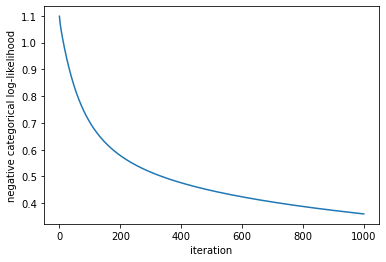

In [6]:

# optimization

w0_flat = np.zeros(5 * 3) # 4 features + bias, 3 classes
w_opt_flat, loss_opt, x_history, f_x_history = \
   minimize(lambda w: objective_cat(w, train_features, oh_train_labels),
            lambda w: d_objective_cat(w, train_features, oh_train_labels),
            w0_flat, 1e-2, 1000)

w_opt = np.reshape(w_opt_flat, [5, 3])

# plotting and evaluation
print("Final Loss:", loss_opt)
plt.figure()
plt.plot(f_x_history)
plt.xlabel("iteration")
plt.ylabel("negative categorical log-likelihood")

train_pred = softmax(train_features @ w_opt)
train_acc = np.count_nonzero(np.argmax(train_pred, axis=-1) == np.argmax(oh_train_labels, axis=-1))
train_acc /= train_labels.shape[0]
test_pred = softmax(test_features @ w_opt)
test_acc = np.count_nonzero(np.argmax(test_pred, axis=-1) == np.argmax(oh_test_labels, axis=-1))
test_acc /= test_labels.shape[0]
print("Train Accuracy:", train_acc, "Test Accuracy:", test_acc)

## 2.) k-NN (3 Points)
Here we implement a simple k-NN approach. As we want to use it for classification now and later for regression, we choose a modular approach. Firstly we implement a function that returns the $k$ nearest neighbour points' x-values and (target) y-values, given a querry point. Then we implement a function to do a majority vote for classification, given the (target) y-values of the k nearest points. Note that we use the "real" labels, not the one-hot encoding for the k-NN classifier.

Work flow and hints (get_k_nearest):
- Compute the distance (e.g. Euclidean) between the query point to all data points.
- Sort the data points according to their distance to the query point. Sort indices can be more efficient.
- Get the K nearest points, return their x and y values.

In [7]:
def get_k_nearest(k: int, query_point: np.ndarray, x_data: np.ndarray, y_data: np.ndarray) \
    -> Tuple[np.ndarray, np.ndarray]:                                                                                        
    """
    :param k: number of nearest neigbours to return 
    :param query_point: point to evaluate, shape [dimension]
    :param x_data: x values of the data [N x input_dimension]
    :param y_data: y values of the data [N x target_dimension]
    :return k-nearest x values [k x input_dimension], k-nearest y values [k x target_dimension]
    """
    #---------------------------------------------------------------
    # TODO
    #---------------------------------------------------------------
    
    # 1. get N count of x_data
    x_rows = np.shape(x_data)[0]
    
    # 2. calculate the Eucleadian distance between query_point x_data and y_data
    eucl_dis_x = np.linalg.norm(x_data - query_point, axis=1)

    # 3. return k-nearest points, not fully sorted for performance reasons
    dis_part_sorted = np.argpartition(eucl_dis_x, k)

    # 4. cut back to required dimensions
    return x_data[dis_part_sorted][:k], y_data[dis_part_sorted][:k]

def majority_vote(y: np.ndarray) -> int:
    """
    :param y: k nearest targets [K]
    :return the number x which occours most often in y. 
    """
    #---------------------------------------------------------------
    # TODO
    #---------------------------------------------------------------
    
    # find most frequent element
    return np.argmax(np.bincount(y))

We run the classifier and measure the accuracy. For $k=5$ it should be $1.0$.

In [8]:
k = 5

predictions = np.zeros(test_features.shape[0])
for i in range(test_features.shape[0]):
    _, nearest_y = get_k_nearest(k, test_features[i], train_features, train_labels)
    predictions[i] = majority_vote(nearest_y)

print("Accuracy: ", np.count_nonzero(predictions == test_labels) / test_labels.shape[0])

Accuracy:  1.0


## 3.) Hold-out and Cross Validation
In this part of the exercise we will have a closer look on the hold-out and cross validation methods for model selection. We will apply these methods to do model selection for different regression algorithms below.

Let's first have a look at the data. Note that the data is given as a tensor of shape [20 x 50 x 1], corresponding to 20 different data sets (drawn from the same ground truth function) with 50 data points each. The data is 1-dimensional. 

**Note:** 
In practice we typically have only one dataset available. We evaluate hold-out and cross validation for 20 different datasets here only to get a feeling for the robustness of these methods.

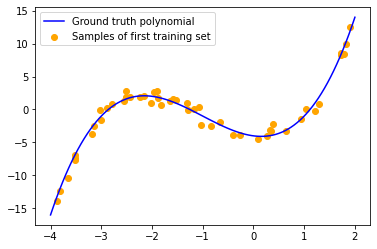

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(33)

# Load 20 training sets with 50 samples in each set
x_samples = np.load('x_samples.npy')    # shape: [20, 50, 1]
y_samples = np.load('y_samples.npy')    # shape: [20, 50, 1]

# Load the ground truth data
x_plt = np.load('x_plt.npy')
y_plt = np.load('y_plt.npy')

# Plot the data (for the training data we just use the first training set)
plt.plot(x_plt, y_plt, c="blue", label="Ground truth polynomial")
plt.scatter(x_samples[0, :, :], y_samples[0, :, :], c="orange", label="Samples of first training set")
plt.legend()


### Utility Functions for Plotting
Before we start, we define some helper functions which we will make use of later on. You do not need to implement anything yourself here.

In [10]:
def plot(mse_val:np.ndarray, mse_train:np.ndarray, x_axis, m_star_idx:int, x_plt:np.ndarray, y_plt: np.ndarray,
         x_samples:np.ndarray, y_samples:np.ndarray, model_best, model_predict_func:callable):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plot_error_curves(mse_val, mse_train, x_axis, m_star_idx)
    plt.subplot(122)
    plot_best_model(x_plt, y_plt, x_samples, y_samples, model_best, model_predict_func)

In [11]:
def plot_error_curves(MSE_val: np.ndarray, MSE_train:np.ndarray, x_axis, m_star_idx: int):
    plt.yscale('log')
    plt.plot(x_axis, np.mean(MSE_val, axis=0), color='blue', alpha=1, label="mean MSE validation")
    plt.plot(x_axis, np.mean(MSE_train, axis=0), color='orange', alpha=1, label="mean MSE train")
    plt.plot(x_axis[m_star_idx], np.min(np.mean(MSE_val, axis=0)), "x", label='best model')
    plt.xticks(x_axis)
    plt.xlabel("Model complexity")
    plt.ylabel("MSE")
    plt.legend()
    
def plot_best_model(x_plt: np.ndarray, y_plt: np.ndarray, x_samples: np.ndarray, y_samples:np.ndarray, 
                    model_best, model_predict_func: callable):
    plt.plot(x_plt, y_plt, color='g', label="Ground truth")
    plt.scatter(x_samples, y_samples, label="Noisy data", color="orange")
    f_hat = model_predict_func(model_best, x_plt)
    plt.plot(x_plt, f_hat, label="Best model")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
def plot_bars(M, std_mse_val_ho, std_mse_val_cv):
    models = np.arange(1, M+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.bar(models, std_mse_val_ho, yerr=np.zeros(std_mse_val_ho.shape), align='center', alpha=0.5, ecolor='black', 
               color='red', capsize=None)
    ax1.bar(models, std_mse_val_cv, yerr=np.zeros(std_mse_val_cv.shape), align='center', alpha=0.5, ecolor='black', 
               color='blue', capsize=None)
    ax1.set_xticks(models)
    ax1.set_xlabel('Model complexity')
    ax1.set_ylabel('Standard deviation')
    ax1.set_yscale('log')
    ax1.set_xticklabels(models)
    ax1.set_title('Standard Deviations of MSEs')
    ax1.yaxis.grid(True)
    plt.legend(['HO', 'CV'])

### 3.1) Hold-Out Method (4 Points)
We will implement the hold-out method for model selection in this section. First, we require a function to split a dataset into a training set and a validation set. Please fill in the missing code snippets. Make sure that you follow the instructions written in the comments.

In [12]:
def split_data(data_in: np.ndarray, data_out: np.ndarray, split_coeff: float)->Tuple[dict, dict]:
    """
    Splits the data into a training data set and a validation data set. 
    :param data_in: The input data which we want to split, shape: [n_data x indim_data] 
    :param data_out: The output data which we want to split, shape: [n_data x outdim_data]
        Note: each pair of data points with index i in data_in and data_out is considered as a 
          training/validation sample: (x_i, y_i)
    :param split_coeff: A value between [0, 1], which determines the index to split data into test and validation set
                        according to: split_idx = int(n_data*split_coeff)
    :return: A tuple of 2 dictionaries: the first element in the tuple is the training data set dictionary
             containing the input data marked with key 'x' and the output data marked with key 'y'.
             The second element in the tuple is the validation data set dictionary containing the input data 
             marked with key 'x' and the output data marked with key 'y'.
    """
    n_data = data_in.shape[0]
    # We use a dictionary to store the training and validation data. 
    # Please use 'x' as a key for the input data and 'y' as a key for the output data in the dictionaries
    # for the training data and validation data.
    train_data = {}
    val_data = {}
    #---------------------------------------------------------------
    # TODO
    #---------------------------------------------------------------

    # calculate split index as given above
    split_idx = int(n_data * split_coeff)
    
    train_data['x'], val_data['x'] = np.split(data_in, [split_idx])
    train_data['y'], val_data['y'] = np.split(data_out, [split_idx])

    return train_data, val_data

This function implements the hold-out method. We split the dataset into a training and a validation data set (using the split_data function you have implemented above). Then, we train a model for a range of complexity values on the training set and choose the model complexity with the best MSE on the validation set. 

The function expects a callable `fit_func` and a callable `predict_func`. We will pass different functions to this argument depending on the regression algorithm we consider. The `fit_func` function returns model parameters obtained by training a given model with a given complexity on a given training data set. The `predict_func` function computes predictions using a given model with a given complexity. For more information, have a look at the comments.

As noted above, we do hold-out for 20 different datasets to get a feeling for the robustness of this method. To this end, we compute the standard deviation of the resulting MSEs over the 20 datasets.

You do not need to implement anything here.

In [13]:
def eval_hold_out(M: int, split_coeff: float, fit_func: callable, predict_func: callable) -> float:
    """
    :param M: Determines the range of model complexity parameters. 
              We perform the hold_out method for model complexities (1, ..., M).
    :param split_coeff: A value between [0, 1] determines the index to split data (cf. split_data function).
    :param fit_func: Callable which fits the model: 
                     (x_train: np.ndarray, y_train: np.ndarray, complexity_parameter: int) -> model_parameters: np.ndarray
    :param predict_func: Callable which computes predictions with the model: 
                         (model_parameters: np.ndarray, x_val: np.ndarray) -> y_pred_val: np.ndarray
    """
    n_datasets = 20
    mse_train_ho = np.zeros((n_datasets, M))
    mse_val_ho = np.zeros((n_datasets, M))
    
    for d in range(n_datasets):
        # Extract current data set and split it into train and validation data
        c_x_samples = x_samples[d, :, :]  
        c_y_samples = y_samples[d, :, :]
        train_data, val_data = split_data(c_x_samples, c_y_samples, split_coeff)
        
        for m in range(M):
            # Train model with complexity m on training set
            p = fit_func(train_data['x'], train_data['y'], m + 1)
            
            # Compute MSE on validation set
            y_pred_val = predict_func(p, val_data['x'])
            mse_val_ho[d, m] = np.mean((y_pred_val - val_data['y'])**2)
            
            # For comparison, compute the MSE of the trained model on current training set
            y_pred_train = predict_func(p, train_data['x'])
            mse_train_ho[d, m] = np.mean((y_pred_train - train_data['y'])**2)
                    
    # Compute mean and std-deviation of MSE over all datasets
    mean_mse_train_ho = np.mean(mse_train_ho, axis=0)
    mean_mse_val_ho = np.mean(mse_val_ho, axis=0)
    std_mse_train_ho = np.std(mse_train_ho, axis=0)
    std_mse_val_ho = np.std(mse_val_ho, axis=0)
    
    # Pick model with best mean validation loss
    m_star_ho = np.argmin(mean_mse_val_ho) 
    print("Best model complexity determined with hold-out method: {}".format(m_star_ho + 1))
    
    # Plot predictions with best model (use only the first data set for better readability)
    train_data, val_data = split_data(x_samples[0, :, :], y_samples[0, :, :], split_coeff)
    p_best_ho = fit_func(train_data['x'], train_data['y'], m_star_ho + 1)
    plot(mse_val_ho, mse_train_ho, np.arange(1, M+1), m_star_ho, x_plt, y_plt,
         x_samples[0, :, :], y_samples[0, :, :], p_best_ho, predict_func)
    
    return std_mse_val_ho

### 3.2) k-Fold-Cross Validation Method (4 Points)
We will now implement the $k$-fold cross validation method for model selection in this section. In contrast to the hold-out method, we do not use a single split of a given dataset into a training and validation sets, but rather $k$ different splits. Refer to the lecture slide 21 for our convention on how to define the $i$-th split.

Please fill in the missing code snippets. Make sure that you follow the instructions written in the comments. You can refer to the `eval_hold_out`-function above for inspiration (note that for clarity we split the logic into two separate functions `k_fold_cross_validation` and `eval_k_fold_cross_validation` here).

In [14]:
def k_fold_cross_validation(data_in: np.ndarray, data_out: np.ndarray, m: int, k: int, fit_func: callable, 
                            predict_func: callable) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform k-fold cross validation for a model with complexity m on data (data_in, data_out). 
    Return the mean squared error incurred on the training and the validation data sets.
    :param data_in: The input data, shape: [N x indim_data] 
    :param data_out: The output data, shape: [N x outdim_data]
    :param m: Model complexity parameter. 
    :param k: Number of partitions of the data set (not to be confused with k in kNN).
    :param fit_func: Callable which fits the model: 
                     (x_train: np.ndarray, y_train: np.ndarray, complexity_parameter: int) -> model_parameters: np.ndarray
    :param predict_func: Callable which computes predictions with the model: 
                         (model_parameters: np.ndarray, x_val: np.ndarray) -> y_pred_val: np.ndarray
    :return mse_train: np.ndarray containg the mean squarred errors incurred on the training set for each split k, shape: [k]
    :return mse_val: np.ndarray containing the mean squarred errors incurred on the validation set for each split, shape: [k]
    """
    
    # Check consistency of inputs and prepare some constants
    n_data = data_in.shape[0]  # total number of datapoints
    assert k <= n_data  # number of partitions has to be smaller than number of data points
    assert n_data % k == 0  # we assume that we can split the data into k equally sized partitions here
    n_val_data = n_data // k  # number of datapoints in each validation set
    
    ind = np.arange(0, n_data)  
    
    # Prepare return values
    mse_train = np.zeros(k)
    mse_val = np.zeros(k)
    
    for i in range(k):
        # 1: Prepare i-th partition into training and validation data sets (cf. lecture slide 21)
        #---------------------------------------------------------------
        # TODO   
        #---------------------------------------------------------------
        val_idx = ind[n_val_data * i:n_val_data * i + n_val_data]
        # every other element is training element
        train_idx = np.setdiff1d(ind,val_idx)
        
        # 2: Fit model on training set
        #---------------------------------------------------------------
        # TODO
        #---------------------------------------------------------------
        train_data = {}
        val_data = {}

        # select elements using masked indices
        train_data['x'], val_data['x'] = data_in[train_idx], data_in[val_idx]
        train_data['y'], val_data['y'] = data_out[train_idx], data_out[val_idx]

        # 3: Compute predictions on training set and validation set
        #---------------------------------------------------------------
        # TODO
        #---------------------------------------------------------------
        
        # Use here the 'fit_func' function. Expects (train_in:np.ndarray, train_out: np.ndarray, m)
        p = fit_func(train_data['x'], train_data['y'], m)
        
        # 4: Compute the mean squarred error for the training and validation sets
        #---------------------------------------------------------------
        # TODO
        # mse_val[i] =
        # mse_train[i] = 
        #---------------------------------------------------------------

        # Use here the 'predict_func' function. Expects (model you have fitted, data you want to make predictions). 
        f_hat_train = predict_func(p, train_data['x'])
        f_hat_val = predict_func(p, val_data['x'])

        mse_train[i] = np.mean((f_hat_train - train_data['y'])**2)
        mse_val[i] = np.mean((f_hat_val - val_data['y'])**2)    

    return mse_train, mse_val

This function will uses the functions you have implemented to evaluate the robustness of the k-fold cross validation method. Similar to the `eval_held_out` function above, it will perform cross validation on the 20 different data sets we have loaded at the beginning and return the standard deviation of the mean squarred errors over the 20 data sets of each different model it is tested on.

In [15]:
def eval_k_fold_cross_validation(M: int, k: int, fit_func:callable, predict_func: callable) -> float:
    """
    :param M: Determines the range of model complexity parameters. 
              We perform the cross-validation method for model complexities (1, ..., M).
    :param k: Number of partitions of the data set (not to be confused with k in kNN).
    :param fit_func: Callable which fits the model: 
                     (x_train: np.ndarray, y_train: np.ndarray, complexity_parameter: int) -> model_parameters: np.ndarray
    :param predict_func: Callable which computes predictions with the model: 
                         (model_parameters: np.ndarray, x_val: np.ndarray) -> y_pred_val: np.ndarray    
    """
    n_datasets = 20
    mse_train_cv = np.zeros((n_datasets, M))
    mse_val_cv = np.zeros((n_datasets, M))
    
    for d in range(n_datasets):
        # Extract current data set and split it into train and validation data
        c_x_samples = x_samples[d, :, :]  
        c_y_samples = y_samples[d, :, :]
        
        for m in range(M):        
            mse_train_k_cv, mse_val_k_cv = k_fold_cross_validation(c_x_samples, c_y_samples, m + 1, k, fit_func, predict_func)
            # Average MSEs over splits
            mse_train_cv[d, m] = np.mean(mse_train_k_cv)
            mse_val_cv[d, m] = np.mean(mse_val_k_cv)
                    
    # Compute mean and std-deviation of MSE over all datasets
    mean_mse_train_cv = np.mean(mse_train_cv, axis=0)
    mean_mse_val_cv = np.mean(mse_val_cv, axis=0)
    std_mse_train_cv = np.std(mse_train_cv, axis=0)
    std_mse_val_cv = np.std(mse_val_cv, axis=0)
    
    # Pick model with best mean validation loss
    m_star_cv = np.argmin(mean_mse_val_cv) 
    print("Best model complexity determined with cross-validation method: {}".format(m_star_cv + 1))
    
    # Plot predictions with best model (use only the first data set for better readability)
    train_data, val_data = split_data(x_samples[0, :, :], y_samples[0, :, :], split_coeff)
    p_best_cv = fit_func(train_data['x'], train_data['y'], m_star_cv + 1)
    plot(mse_val_cv, mse_train_cv, np.arange(1, M+1), m_star_cv, x_plt, y_plt,
         x_samples[0, :, :], y_samples[0, :, :], p_best_cv, predict_func)
    
    return std_mse_val_cv

### 3.3) kNN Regression
We will now apply hold-out and k-fold cross validation on the regression problem using kNN Regression. In the following we provide a fit and an evaluate function for kNN, which we will use as the callables `fit_func` and `eval_func` for hold-out and cross validation.

In [16]:
def fit_knn_regressor(train_in: np.ndarray, train_out:np.ndarray, k: int) -> dict:
    """
    Fit a k-nearest neighbors model to the data. This function just returns a compact representation of the input data
    data provided, i.e. it stores the training in- and output data together with the number of k neighbors in a dictionary.
    :param train_in: The training input data, shape: [N x input dim]
    :param train_out: The training output data, shape: [N x output dim]
    :param k: The parameter determining how many nearest neighbors to consider
    :return: A dictionary containing the training data and the parameter k for k-nearest-neighbors.
             Key 'x': the training input data, shape: [N x input dim]
             Key 'y': the training output data, shape: [N x output dimension]
             Key 'k': the parameter determining how many nearest neighbors to consider
    """
    
    model = {'x': train_in, 'y': train_out, 'k': k}
    return model

In [17]:
def predict_knn_regressor(model, data_in: np.ndarray) -> np.ndarray:
    """
    This function will perform predictions using a k-nearest-neighbor regression model given the input data. 
    Note that knn is a lazy model and requires to store all the training data (see dictionary 'model').
    :param model: A dictionary containing the training data and the parameter k for k-nearest-neighbors.
                  Key 'x': the training input data, shape: [N x input dim]
                  Key 'y': the training output data, shape: [N x output dimension]
                  Key 'k': the parameter determining how many nearest neighbors to consider
    :param data_in: The data we want to perform predictions on, shape: [N x input dimension]
    :return prediction based on k nearest neighbors (mean of the k - neares neighbors) (shape[N x output dimension])
    """
    # Prepare data
    if len(data_in.shape) == 1:
        data_in = np.reshape(data_in, (-1, 1))
    train_data_in = model['x']
    train_data_out = model['y']
    k = model['k']
    if len(train_data_in.shape) == 1:
        train_data_in = np.reshape(train_data_in, (-1, 1))
    
    # Perform predictions
    predictions = np.zeros((data_in.shape[0], train_data_out.shape[1]))
    for i in range(data_in.shape[0]):
        _, nearest_y = get_k_nearest(k, data_in[i, :], train_data_in, train_data_out)   
        # we take the mean of the nearest samples to perform predictions
        predictions[i, :] = np.mean(nearest_y, axis=0)
    
    return predictions

### 3.3.1) Apply Hold-Out and Cross-Validation to kNN Regression 

We now apply $k$-nearest neighbor regression on our data set and use the hold-out and cross-validation methods to determine the complexity parameter of this model, i.e., the number $k$ of nearest neighbors to consider.
As described above, we furthermore plot and compare the standard deviations of the mean squared errors for each model based on the 20 data sets to get a feeling of the robustness of hold-out and cross validation.

In [18]:
M_knn = 20        # Maximum number k of nearest neighbors 
split_coeff = 0.8 # Split coefficient for the hold-out method
k = 10            # Number of splits for the cross validation method

Best model complexity determined with hold-out method: 2
Best model complexity determined with cross-validation method: 2


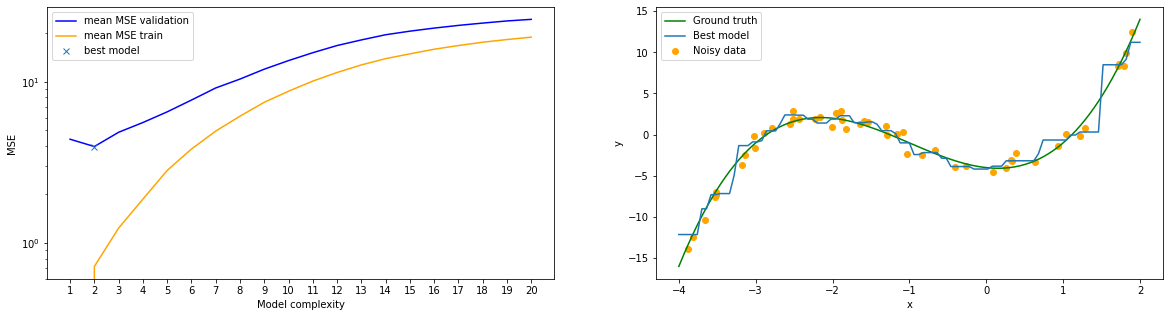

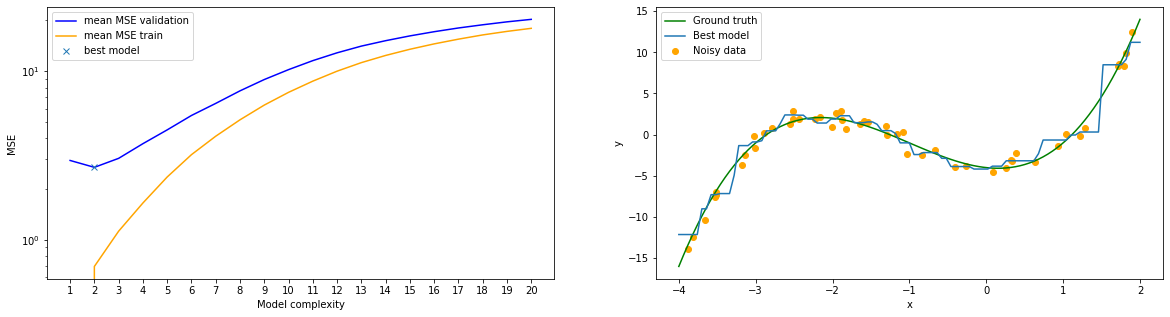

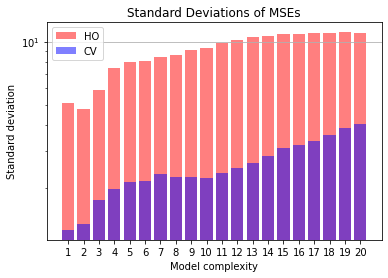

In [19]:
# Evaluate hold-out method
std_mse_val_ho_knn = eval_hold_out(M=M_knn, split_coeff=split_coeff, fit_func=fit_knn_regressor, 
                     predict_func=predict_knn_regressor)

# Evaluate cross validation method
std_mse_val_cv_knn = eval_k_fold_cross_validation(M=M_knn, k=k, fit_func=fit_knn_regressor, 
                                                  predict_func=predict_knn_regressor)

# Plot the standard deviations
plot_bars(M_knn, std_mse_val_ho_knn, std_mse_val_cv_knn)

The first two rows in the cell above show the errorplots and the best model's prediction for hold out (first row) and cross validation (second row), respectively. The last row shows the standard deviation of the mean squarred error over the 20 different data sets incurred by each model.

### 3.4) Forests
We will now apply hold-out and $k$-fold-cross validation on regression with forests. As for k-nearest neighbor regression above, we provide a fit and an evaluate function for forests. Note that we have two different functions for fitting a forest model. In `fit_forest_fixed_n_trees` we investigate the behavior of the algorithm when fixing the number of trees to $1$ and varying the number of samples per leaf. In `fit_forest_fixed_n_samples_leaf` we fix the number of samples per leaf to $1$ and investigate the behavior of the algorithm when varying the number of trees. The evaluation function can be used for both models.

In [20]:
def fit_forest_fixed_n_trees(train_in: np.ndarray, train_out:np.ndarray, min_samples_leaf: int):
    """
    This function will fit a forest model based on a fixed number of trees (can not be change when using this 
    function, is set globally)
    :param train_in: the training input data, shape [N x input dim]
    :param train_out: the training output data, shape [N x output dim]
    :param min_samples_leaf: the number of samples per leaf to be used 
    """
    model = RandomForestRegressor(n_estimators=1, min_samples_leaf=min_samples_leaf)
    model.fit(train_in, train_out)
    return model

In [21]:
def fit_forest_fixed_n_samples_leaf(train_in: np.ndarray, train_out:np.ndarray, n_trees: int):
    """
    This function will fit a forest model based on a fixed number of sample per leaf (can not be change when 
    using this function, is set globally)
    :param train_in: the training input data, shape [N x input dim]
    :param train_out: the training output data, shape [N x output dim]
    :param n_trees: the number of trees in the forest 
    """
    model = RandomForestRegressor(n_estimators=n_trees, min_samples_leaf=1)
    model.fit(train_in, train_out)
    return model

In [22]:
def predict_forest(model, data_in: np.ndarray)->np.ndarray:
    """
    This function will perform predictions using a forest regression model on the input data. 
    :param model: the forest model from scikit learn (fitted before)
    :param data_in: :param data_in: the data we want to perform predictions (shape [N x input dimension])
    :return prediction based on chosen minimum samples per leaf (shape[N x output dimension]
    """
    y = model.predict(data_in)
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
    return y

### 3.4.1) Apply Hold-out and Cross-validation to Forests (Fixed Number of Trees)

We apply forest regression with a fixed number of trees of $1$ and use hold-out and cross-validation to determine the complexity parameter of this model, i.e., the number of samples per leaf. As described above, we furthermore plot and compare the standard deviations of the mean squared errors for each model based on the 20 data sets to get a feeling of the robustness of hold-out and cross validation.

In [23]:
M_n_samples_leaf = 10       # Maximum number of samples per leaf
split_coeff = 0.8           # Split coefficient for the hold-out method
k = 10                      # Number of splits for the cross validation method

Best model complexity determined with hold-out method: 1
Best model complexity determined with cross-validation method: 1


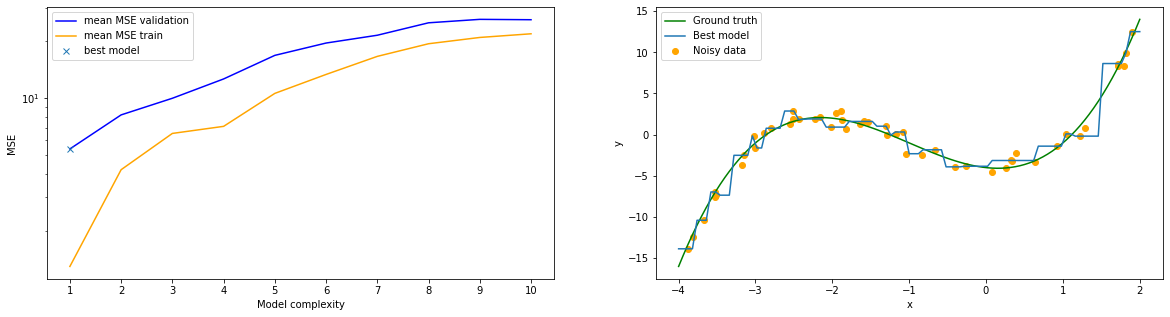

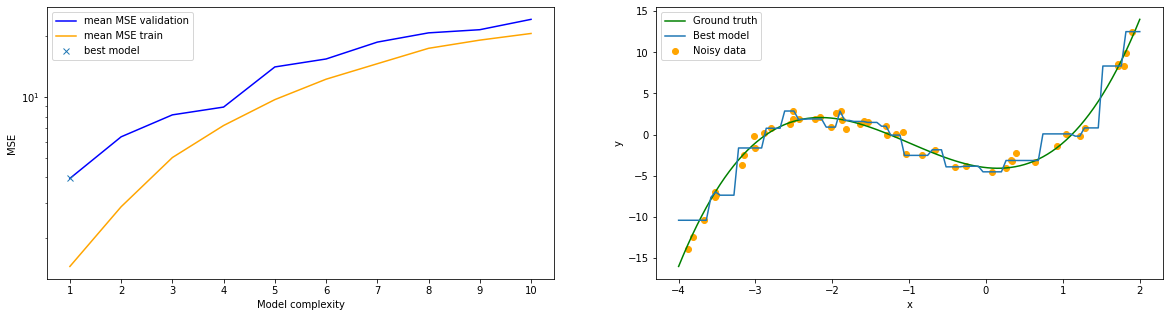

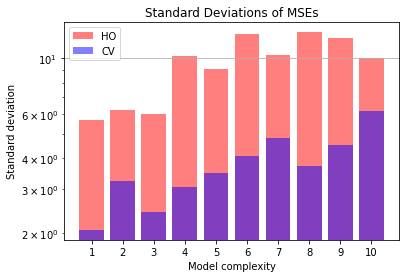

In [24]:
# Hold-out method
std_mse_val_ho_forest_fixed_n_trees = eval_hold_out(M=M_n_samples_leaf, split_coeff=split_coeff, 
                                                    fit_func=fit_forest_fixed_n_trees, 
                                                    predict_func=predict_forest)
# Cross validation method
std_mse_val_cv_forest_fixed_n_trees = eval_k_fold_cross_validation(M=M_n_samples_leaf, k=k, fit_func=fit_forest_fixed_n_trees, 
                                                                   predict_func=predict_forest)

# Plot the standard deviations
plot_bars(M_n_samples_leaf, std_mse_val_ho_forest_fixed_n_trees, std_mse_val_cv_forest_fixed_n_trees)

The first two rows in the cell above show the errorplots and the best model's prediction for hold out (first row) and cross validation (second row), respectively. The last row shows the standard deviation of the mean squarred error over the 20 different data sets incurred by each model.

### 3.4.2) Apply Hold-out and Cross-validation to Forests (Fixed Number of Samples per Leaf) 
We apply forest regression with a fixed number of samples per leaf of $1$ and use hold-out and cross-validation to determine the complexity parameter of this model, i.e., the number of trees. As described above, we furthermore plot and compare the standard deviations of the mean squared errors for each model based on the 20 data sets to get a feeling of the robustness of hold-out and cross validation.

In [25]:
M_n_trees = 20              # Maximum number of trees
split_coeff = 0.8           # Split coefficient for the hold-out method
k = 10                      # Number of splits for the cross validation method

Best model complexity determined with hold-out method: 19
Best model complexity determined with cross-validation method: 17


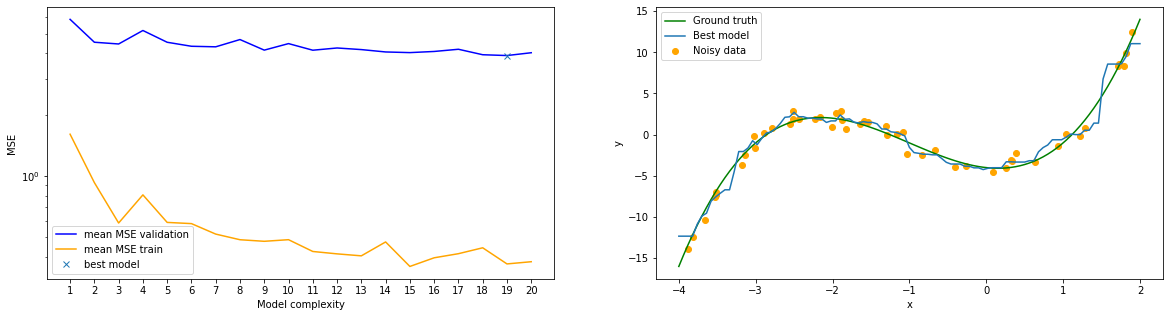

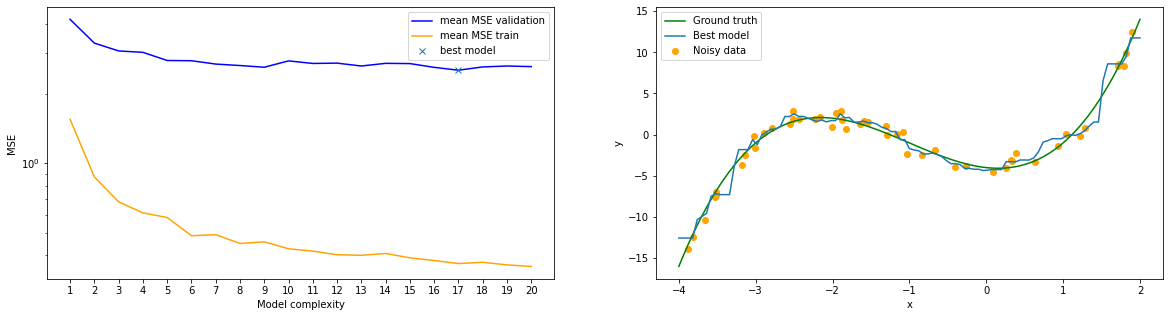

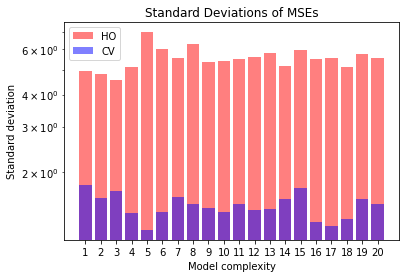

In [26]:
# Hold-out method
std_mse_val_ho_forest_fixed_n_samples = eval_hold_out(M=M_n_trees, split_coeff=split_coeff, 
                                                      fit_func=fit_forest_fixed_n_samples_leaf,  
                                                      predict_func=predict_forest)
# Cross-validation method
std_mse_val_cv_forest_fixed_n_samples = eval_k_fold_cross_validation(M=M_n_trees, k=k, 
                                                                     fit_func=fit_forest_fixed_n_samples_leaf, 
                                                                     predict_func=predict_forest)


# Plot the standard deviations
plot_bars(M_n_trees, std_mse_val_ho_forest_fixed_n_samples, std_mse_val_cv_forest_fixed_n_samples)

The first two rows in the cell above show the errorplots and the best model's prediction for hold out (first row) and cross validation (second row), respectively. The last row shows the standard deviation of the mean squarred error over the 20 different data sets incurred by each model.

### 3.5) Comparisons

#### 3.5.1) (1 Point)
Comparing the error plots from section 3.4.2) to the error plots from 3.3.1) and 3.4.1) we observe that the validation error does not increase with the number of trees. Give an intution for this observation.

**Solution:**

As a random forest is a combination of several trees, the validation error is generally speaking more stable. By fixing the number of samples per leaf, one can make sure, that the average for each leaf is calculated from a minimum amount of observations. Which then leads to a more stable validation error.

#### 3.5.2) (1 Point)
Compare the standard deviation plots from the last three sections. What is the main difference between the hold-out and cross validation methods? Explain the reason for the observed behavior.

**Solution:**

Generally speaking the standard deviation for the Cross Validation method is much smaller, as compared to the hold-out-method the *entire* dataset get's used for training by "rotating" the $k$-fold, that is used for validation. Therefore, more data for training the models is available and results are more stable. Considering that our datasets are rather small, this is vital. 

Also, an averaging over the splits takes place, which leads to a lower variance.